In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
M = np.load('val_loss_matrix.npy')

print(M.shape)

m = np.mean(M,0)
m.shape
plt.figure()
plt.plot(M.T,'k', linewidth = 0.1)
plt.plot(m,'r', linewidth = 2)

M_centered = M - m

C = np.dot(M_centered.T,M_centered)

plt.figure()
plt.imshow(C)
plt.colorbar()

(1024, 200)


NameError: name 'plt' is not defined

(1024, 200)
(200,) (200,)
(200,)


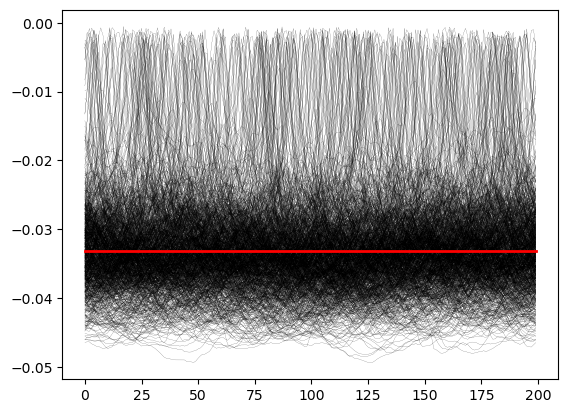

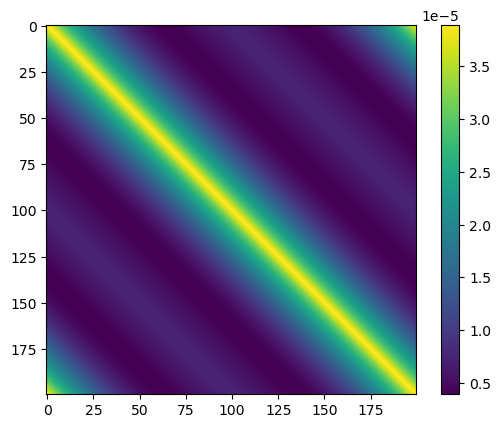

In [3]:
print(M.shape)

m_estimated = np.mean(M,0)
m_stationary = np.ones(200)*np.mean(m_estimated)

std_estimated = np.std(M,0)
std_stationary = np.ones(200)*np.std(std_estimated)

print(m_stationary.shape,std_stationary.shape)

plt.figure()
plt.plot(M.T,'k', linewidth = 0.1)
plt.plot(m_stationary,'r', linewidth = 2)

M_centered = (M - m_estimated) / np.sqrt(M.shape[0])

C = np.dot(M_centered.T,M_centered)

C_junk = np.zeros(200)
for i in range(200):
    C_junk += np.roll(C[:,i],-i)
C_junk /= 200
print(C_junk.shape)

C_stationary = np.zeros((200,200))
for i in range(200):
    C_stationary[:,i] += np.roll(C_junk,i)



plt.figure()
plt.imshow(C_stationary)
plt.colorbar()

In [ ]:
with open('kernel.npy', 'wb') as writer:
    np.save(writer, C_stationary)

In [2]:
def rbfkernel(
        X1: np.ndarray, # array of m points (m x d)
        X2: np.ndarray, # array of m points (n x d)
        l: float = 1.0,
        sigma_f: float = 1.0
) -> np.ndarray: # (m x n) matrix
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


def m(
        X: np.ndarray, # array of n points (n x d)
        mean_value: float = 0.,
) -> np.ndarray: # array of n points (n x d) filled with zeros
    return np.full_like(X, mean_value)

In [ ]:
from typing import Callable, Tuple
from numpy.linalg import inv

def posterior(
        X_test: np.ndarray,
        X_train: np.ndarray,
        Y_train: np.ndarray,
        m,
        kernel
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_test: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        kernel: covariance function (kernel)
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K_tn = kernel(X_train, X_train)
    K_tt = kernel(X_test, X_train)
    K_ts = kernel(X_test, X_test)
    
    mu_test = m(X_test) + (K_tt @ inv(K_tn) @ (Y_train - m(X_train)))

    cov_test = K_ts - (K_tt @ inv(K_tn) @ K_tt.T)
    
    return mu_test, cov_test

In [22]:
def plot_gp(mu, cov, X_test, X_train=None, Y_train=None, samples=[]):
    X_test = X_test.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))

    plt.figure()
    
    # plot mean function
    plt.plot(X_test, mu, label='Mean')
    # plot uncertainty region
    plt.fill_between(X_test, mu + uncertainty, mu - uncertainty, alpha=0.1)

    # plot functions sampled from multivariate distribution defined by GP
    for i, sample in enumerate(samples):
        plt.plot(X_test, sample, lw=1, ls='--', label=f'Sample {i+1}')

    # plot training points
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rX', markersize=3.)

    plt.legend()

In [ ]:
rng = np.random.default_rng(seed=12345)

## I. RBF kernel example

### Prior

In [5]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)
kernel = rbfkernel

# Mean and covariance of the prior
mu = m(X)
cov = kernel(X, X, l=1.0, sigma_f=1.0)

# Draw three samples from the prior
samples = rng.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu, cov, X, samples=samples)

# Plot covariance matrix
plt.figure()
plt.imshow(cov)
plt.colorbar();

NameError: name 'rbfkernel' is not defined

### Posterior

In [ ]:
# Noise free training data
X_train = np.array([-4, 2]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior distribution
mu_test, cov_test = posterior(X, X_train, Y_train, m, kernel)

samples = np.random.multivariate_normal(mu_test.ravel(), cov_test, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu_test, cov_test, X, X_train, Y_train, samples=samples)

# Plot covariance matrix
plt.figure()
plt.imshow(cov_test)
plt.colorbar();

## II. Custom periodic kernel example

In [ ]:
def custom_kernel(X, Y=None):
    """
    Args:
        X: Array of m points (m x d).
        Y: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    grid = np.linspace(-180, 180, 200, endpoint=True)

    if Y is None: Y = X

    K = np.zeros((X.shape[0], Y.shape[0]))

    for i, x in enumerate(X):
        x_i = np.argwhere(grid == x).item()

        for j, y in enumerate(Y):
            y_i = np.argwhere(grid == y).item()

            K[i, j] = C_stationary[x_i, y_i]

    return K

### Prior

In [ ]:
# Finite number of points
X = np.linspace(-180, 180, 200, endpoint=True).reshape(-1, 1)

m_func = lambda x: m(x, mean_value=np.mean(m_estimated).item())
cov_func = custom_kernel

# Mean and covariance of the prior
mu = m_func(X)
cov = cov_func(X)

# Draw three samples from the prior
samples = rng.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu, cov, X, samples=samples)

# Plot covariance matrix
plt.figure()
plt.imshow(cov)
plt.colorbar();

### Posterior

In [ ]:
# Noise free training data

X_train = np.array([[-180.]])
Y_train = np.atleast_2d(M[39][0])

# X_train = np.array([[0.]])
# Y_train = np.atleast_2d(0)

# X_train = np.sort(rng.choice(X, 2))
# Y_train = np.vstack([M[39][np.argwhere(X.ravel() == x_i.item()).item()] for x_i in X_train])

# Compute mean and covariance of the posterior distribution
mu_test, cov_test = posterior(X, X_train, Y_train, m_func, cov_func)

samples = np.random.multivariate_normal(mu_test.ravel(), cov_test, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu_test, cov_test, X, X_train, Y_train, samples=samples)

# Plot covariance matrix
plt.figure()
plt.imshow(cov_test)
plt.colorbar();

## Matching the empirical kernel

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
X = np.linspace(-180, 180, 200, endpoint=True).reshape(-1, 1)

In [ ]:
D = euclidean_distances(X)

In [ ]:
plt.plot(D[0, :], C_stationary[0, :])

In [ ]:
from sklearn.gaussian_process.kernels import ConstantKernel, ExpSineSquared, Sum

In [ ]:
kernel = Sum(
    ConstantKernel(1.) * ExpSineSquared(length_scale=np.sqrt(X.var()) / 300, periodicity=360),
    ConstantKernel(1.) * ExpSineSquared(length_scale=3., periodicity=180),

)

In [ ]:
# cov = kernel(np.zeros_like(X), X)
cov_matched = kernel(X)
cov_scaled = (cov_matched - cov_matched.min()) / (cov_matched.max() - cov_matched.min())

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, cov_matrix in enumerate((C_stationary, cov_scaled)):
    ax[i].imshow(cov_matrix)

    ax[i].set_xticks([0, 100, 199])
    ax[i].set_xticklabels([-180, 0, 180])

    ax[i].set_yticks([0, 100, 199])
    ax[i].set_yticklabels([-180, 0, 180])
    
    
fig.tight_layout();

In [ ]:
plt.plot(D[0, :], C_stationary[0, :], label="empirical")
plt.plot(D[0, :], cov_scaled[0, :], label="matched")
plt.legend();

### Prior

In [ ]:
# Finite number of points
X = np.linspace(-180, 180, 200, endpoint=True).reshape(-1, 1)

m_func = lambda x: m(x, mean_value=np.mean(m_estimated).item())
cov_func = kernel

# Mean and covariance of the prior
mu = m_func(X)
cov = cov_func(X)
cov = (cov - cov.min()) / (cov.max() - cov.min())

# Draw three samples from the prior
samples = rng.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu, cov, X, samples=samples)

# Plot covariance matrix
plt.figure()
plt.imshow(cov)
plt.colorbar();

### Posterior

In [ ]:
X_train = np.array([[-180.]])
Y_train = np.atleast_2d(M[39][0])

# X_train = np.array([[0.]])
# Y_train = np.atleast_2d(0)

# X_train = np.sort(rng.choice(X, 2))
# Y_train = np.vstack([M[39][np.argwhere(X.ravel() == x_i.item()).item()] for x_i in X_train])

# Compute mean and covariance of the posterior distribution
mu_test, cov_test = posterior(X, X_train, Y_train, m_func, cov_func)

samples = np.random.multivariate_normal(mu_test.ravel(), cov_test, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu_test, cov_test, X, X_train, Y_train, samples=samples)

# Plot covariance matrix
plt.figure()
plt.imshow(cov_test)
plt.colorbar();

## Bayesian Optimization (custom implementations)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import autoroot

In [3]:
import numpy as np

In [4]:
from bopt import *

In [5]:
rng = np.random.default_rng(12345)

In [6]:
def objective(X):
    points = np.linspace(-180, 180, 200, endpoint=True)
    indices = [np.abs(points - x.item()).argmin() for x in X]
    
    return M[7][indices]

In [8]:
X = np.linspace(-180, 180, 200, endpoint=True).reshape(-1, 1)
Y = objective(X)

In [9]:
max_idx = np.argmax(Y)
print(f"Maximum: ({X[max_idx].item():.3f}, {Y[max_idx].item():.3f})")

Maximum: (87.739, -0.003)


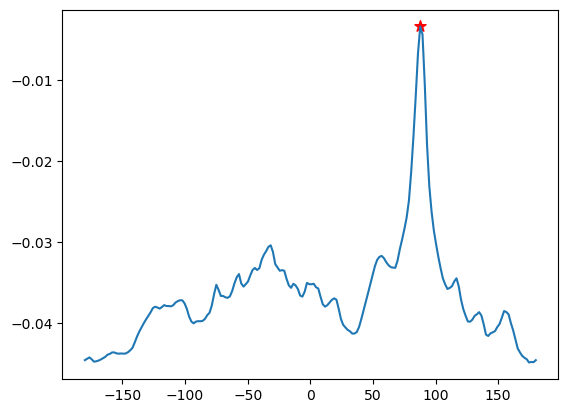

In [12]:
plt.plot(X, Y)
plt.scatter(X[max_idx], Y[max_idx], marker="*", color="red", s=70);

In [13]:
f = objective

sspace = LinearGridSpace(-180, 180, size=100, random_state=12345)

acq_func = AcquisitionFunction(eps=0.0001)

cov_func = CustomKernel(file="../kernel.npy", points=np.linspace(-180, 180, 200, endpoint=True))
mean_func = MeanFunction(mean_value=M.mean())

surrogate = GaussianProcessRegressor(mean_func, cov_func)

boptim = BayesianOptimizer(f, sspace, surrogate, acq_func)

for step in range(1, 16):
    next_point, next_value = boptim.step()

    boptim.log({"x": next_point, "y": next_value}, step=step)

    print(f"step: {step:02d},\trotate by: {next_point:8.3f},\tloss={next_value:6.3f}")
    break

step: 01,	rotate by:   70.909,	loss=-0.031


In [20]:
samples = boptim.surrogate.sample(sspace.points.reshape(-1, 1), X_train=boptim.history.X, Y_train=boptim.history.Y, n_samples=3)

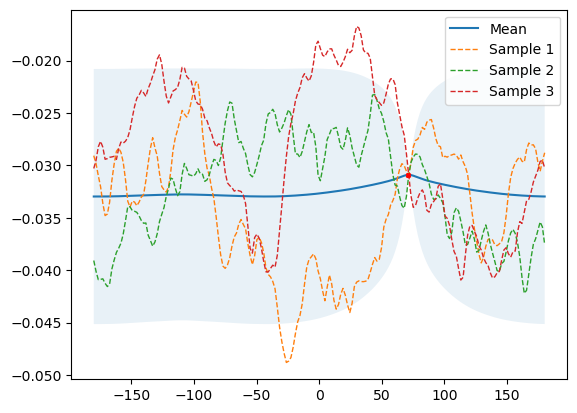

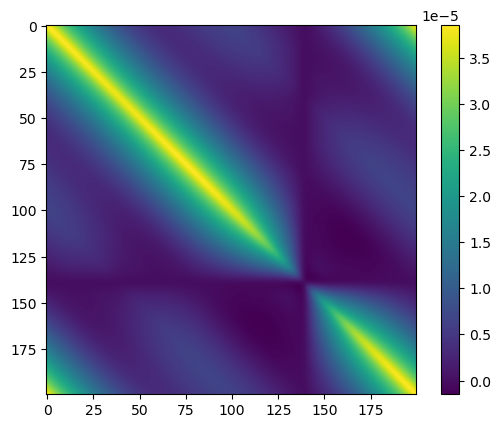

In [23]:
mu_test, cov_test = surrogate.predict(X, boptim.history.X, boptim.history.Y)

samples = rng.multivariate_normal(mu_test.ravel(), cov_test, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu_test, cov_test, X, boptim.history.X, boptim.history.Y, samples=samples)

# Plot covariance matrix
plt.figure()
plt.imshow(cov_test)
plt.colorbar();